## Финальный проект

#### *«Я чувствую себя как функция арктангенса, которая приближается к асимптоте.» — Теория большого взрыва*

Это финальный проект продуктового блока курса «Продуктовые метрики». За него можно получить максимум 60 баллов. На решение отводится **21 календарный день** с момента выдачи. Обратите внимание, что **дедлайны на курсе сразу жёсткие**, а значит отправка решений после них запрещена. Задание выполняется самостоятельно, списывания не допускаются. При обнаружении одинаковых работ балл за задание анулируется у всех студентов, вне зависимости от того, кто у кого списал.

#### **Как сдать домашку?**
1. Создайте закрытый репозиторий в личном гитхаб аккаунте для нашего предмета.
2. Пригласите в него своего ассистента — распределение по ассистентам и их гитхаб юзернеймы находятся в [ведомости](https://docs.google.com/spreadsheets/d/13lHNf6xU6tZhqzVMAb8sV3RgyyDatepwo7FJ6FhZ0vY/edit?usp=sharing) на листочке нашей дисциплины. Это можно сделать в настройках через раздел Collaborators and teams, уровень доступа ассистента должен быть Write.
3. Скачайте этот ноутбук и решите задания (локально или в Google Colab).
4. В репозитории предмета создайте ветку с номером ДЗ (например final_project). В эту ветку запушьте .ipynb-файл с решением. Создайте pull request и добавьте в него ассистента как Reviewer. В этот же PR можете пушить сколько угодно изменений, будем смотреть на последнюю версию до наступления дедлайна.
5. Ссылку на PR продублируйте в форме сдачи (форма будет доступна на LMS Karpov Courses и в Телеграм-канале курса).

Пункты 1-2 проделываются один раз. Если вы прошли эти шаги при сдаче других домашек, повторять их не нужно, начинайте сразу с пункта 3.

**Внимание**: Если вы работаете в Google Colab, также скачивайте .ipynb файл и публикуйте его в репозитории. Ссылки на Colab к сдаче не принимаются.

Все датасеты, с которыми предлагается работать в домашних заданиях, взяты из открытых источников или сгенерированы. Любые паттерны, найденные вне заданной канвы решения, являются случайными и не несут в себе смысла или инсайта.

[Данные](https://github.com/brezhnevaan/hse_product_metrics_course/releases/download/datasets_for_hw/final_project_data.zip)

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests

from statsmodels.tsa.seasonal import STL
from scipy.stats import norm
from scipy.stats import t
import math

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

### Case Study. Улучшение сервиса доставки из ресторанов 🌮

**Легенда**   
Вы присоединились к продуктовой команде сервиса доставки из ресторанов в роли аналитика. Близится планирование следующего квартала, пора готовить бэклог инициатив. Продакт-менеджер особенно беспокоится об удовлетворенности пользователей — за последний месяц выросло число отмен и жалоб на задержки.

Вам поставлена задача: провести исследование текущих значений метрик, выдвинуть гипотезу о проблеме и предложить её решение.

In [19]:
df = pd.read_csv('/content/final_project_delivery.csv')

df.head()

,order_id,order_time,delivery_time,status,cancellation_reason,order_value,delivery_fee,estimated_delivery_time_min,time_to_assign_courier_min,actual_preparation_time_min,travel_time_min,delivery_distance_km,promotion_used,platform,city_region,user_id,user_segment
0,257,2022-11-01 00:01:46,2022-11-01 00:21:52,delivered,NaN,25.73,2.09,27.0,10.2,15.1,5.0,3.48,no,Android,Belem,5737,returning
1,165,2022-11-01 00:06:07,2022-11-01 00:27:01,delivered,NaN,22.00,0.77,13.0,9.0,15.9,5.0,1.29,no,iOS,Parque das Nacoes,4095,new
2,343,2022-11-01 21:07:01,2022-11-01 21:40:07,delivered,NaN,29.90,3.53,44.0,10.6,15.4,15.1,5.88,no,iOS,Parque das Nacoes,15991,returning
3,904,2022-11-01 00:06:48,2022-11-01 00:36:42,delivered,NaN,40.49,2.02,27.0,3.7,16.0,13.9,3.36,no,Android,Alfama,1773,returning
4,555,2022-11-01 00:09:58,2022-11-01 00:57:22,delivered,NaN,35.75,3.48,39.0,5.2,12.3,35.1,5.80,no,iOS,Baixa,5203,returning


Описание данных:

- order_id — уникальный идентификатор заказа
- order_time — timestamp создания заказа
- delivery_time – timestamp доставки заказа
- status — статус заказа, принимает 2 значения: delivered и cancelled
- cancellation_reason — причина отмены заказа: Cancelled by user (отменена пользователем) и No courier available (нет доступных курьеров)
- order_value — стоиомость заказа
- delivery_fee — стоиость доставки
- estimated_delivery_time_min — прогнозное время доставки
- time_to_assign_courier_min — время до назначения курьера
- actual_preparation_time_min — время приготовления заказа рестораном
- travel_time_min — суммарное время на дорогу курьера до ресторана и до конечного пользователя
- delivery_distance_km — расстояние от адреса доставки до адреса ресторана
- promotion_used — был ли заказ совершер с использованием промокода или акции
- platform — платформа, с которой совершен заказ
- city_region — район города, в который планируется доставка
- user_id — уникальный идентификатор пользователя, сделавшего заказ
- user_segment — сегмент пользователя (новый или вернувшийся)    

### Часть 1. Исследование

#### 1. Динамика основных метрик — 3 балла
Рассчитайте и визуализируйте по дням:
- Число заказов, число доставленных заказов (статус delivered);
- Completion Rate (Доставленные заказы / Все заказы), Cancellation Rate (Отмененные заказы / Все заказы);
- Среднее и медианное время доставки в минутах (рассчитывается как разница между delivery_time и order_time), средний чек заказа, среднюю стоимость доставки.

Сделайте выводы:
- Есть ли выраженный тренд?
- Может быть какие-то дни кажутся подозрительными на предмет аномалий?

In [ ]:
# your code is here

In [16]:
# Вспомогательные функции
def get_line_plot(df, x, y, title, annotate=False):
    fig, ax1 = plt.subplots(figsize=(12,6))

    if len(y) == 2:
        ax1.plot(df[x], df[y[0]], label=y[0], color='blue')
        ax1.set_ylabel(y[0])
        plt.xticks(rotation=45)

        if annotate:
            for i, val in enumerate(df[y[0]]):
                ax1.text(df[x].iloc[i], val, f'{val:.2f}', fontsize=9)

        ax2 = ax1.twinx()
        ax2.plot(df[x], df[y[1]], label=y[1], color='green')
        ax2.set_ylabel(f'{y[1]}')
        ax2.tick_params(axis='y')

        if annotate:
            for i, val in enumerate(df[y[1]]):
                ax2.text(df[x].iloc[i], val, f'{val:.2f}', fontsize=9)

        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2,
                   loc='center left', bbox_to_anchor=(1.05, 0.8))

        ax1.grid(True, which='both')
        fig.suptitle(title)
        fig.tight_layout()
        return plt.show()

    else:
        for col in y:
            plt.plot(df[x], df[col], label=col, color='blue')
            if annotate:
                for i, val in enumerate(df[col]):
                    plt.text(df[x].iloc[i], val, f'{val:.2f}', fontsize=9)

        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Metric Value')
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.8))
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
    return plt.show()


In [17]:
def get_several_lines_plot(df, x, y_list, title, annotate=False):
    plt.figure(figsize=(12,6))
    colors = ['green', 'blue', 'orange', 'pink', 'violet']

    for i, col in enumerate(y_list):
        if x == 'date':
            x_axis = df[x]
        else:
            x_axis = df[x].astype(str)
        y_axis = df[col]
        plt.plot(x_axis, y_axis, label=col, color=colors[i])
        if annotate:
            for xi, yi in zip(x_axis, y_axis):
                plt.text(xi, yi, f'{yi:.2f}', fontsize=9, ha='center', va='bottom')

    plt.title(title)
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Metric Value')
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.9))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [18]:
def get_category_plot(df, x_col, metric, cal_column, title, annotate=False):
    plt.figure(figsize=(12,6))
    for cat in df[cal_column].unique():
        temp = df[df[cal_column] == cat]
        plt.plot(temp[x_col], temp[metric], label=cat)
        if annotate:
            for x, y in zip(temp[x_col], temp[metric]):
                plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=8)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.9))
    plt.tight_layout()
    plt.show()


In [20]:
# предобработка
df['order_time'] = pd.to_datetime(df['order_time'])
df['delivery_time'] = pd.to_datetime(df['delivery_time'])
df['date'] = pd.to_datetime(df['order_time'].dt.date)

df['is_delivered'] = df['status'] == 'delivered'
df['is_cancelled'] = df['status'] == 'cancelled'

df['delivery_minutes'] = np.where(
    df['is_delivered'],
    (df['delivery_time'] - df['order_time']).dt.total_seconds() / 60,
    np.nan
)

In [21]:
# ЗАДАНИЕ 1
# агрегируем по дням и посчитаем метрики
df_daily = (
    df.groupby('date', as_index=False)
    .agg(
        orders=('order_id', 'nunique'),
        delivered=('is_delivered', 'sum'),
        cancelled=('is_cancelled', 'sum'),
        avg_delivery_time_mean=('delivery_minutes', 'mean'),
        avg_delivery_time_median=('delivery_minutes', 'median'),
        avg_check=('order_value', 'mean'),
        avg_delivery_fee=('delivery_fee', 'mean')
    )
)
df_daily['completion_rate'] = df_daily['delivered'] / df_daily['orders']
df_daily['cancellation_rate'] = df_daily['cancelled'] / df_daily['orders']

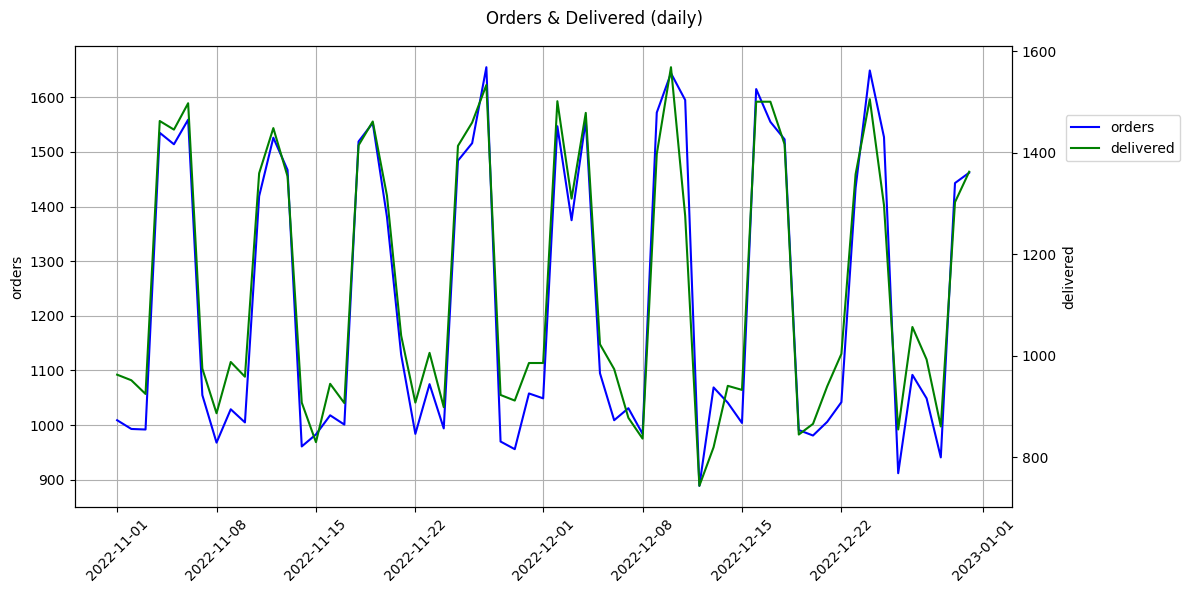

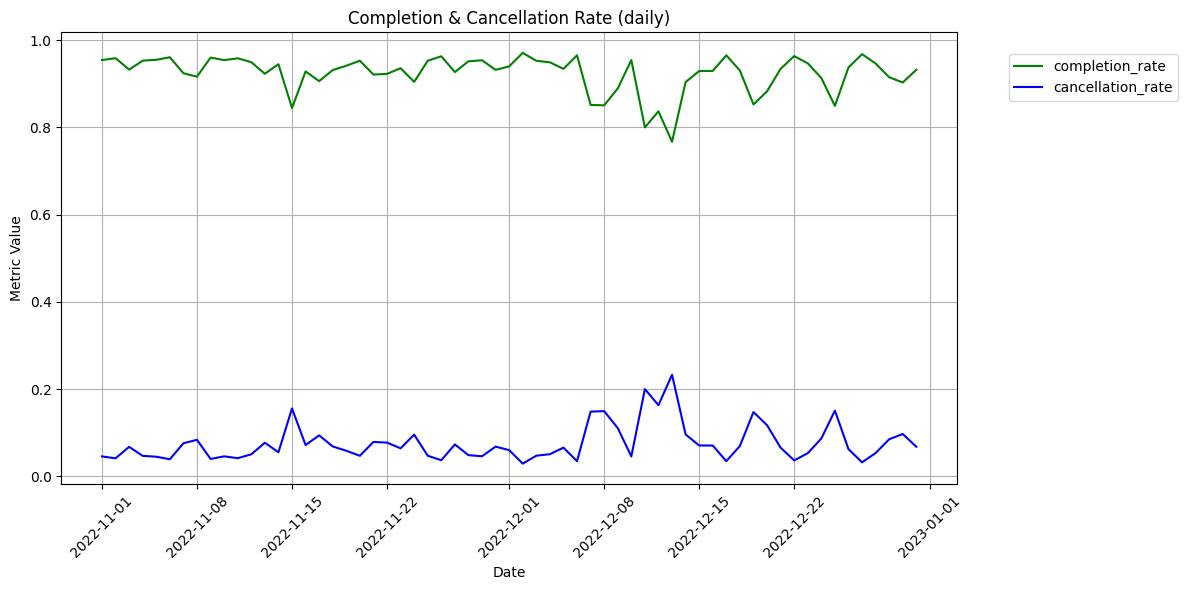

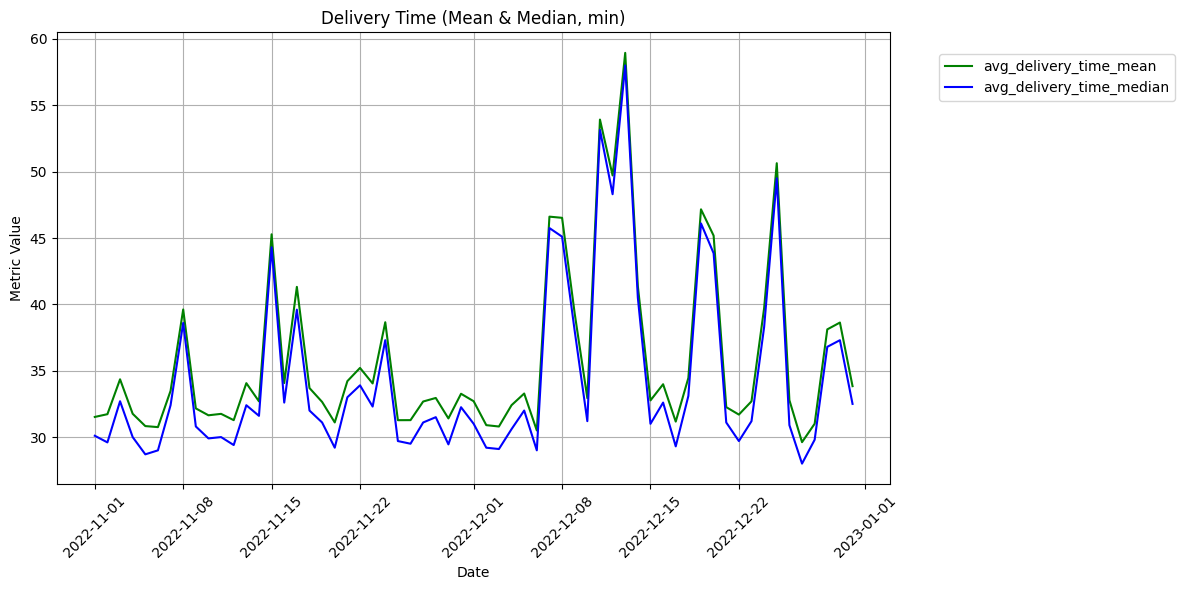

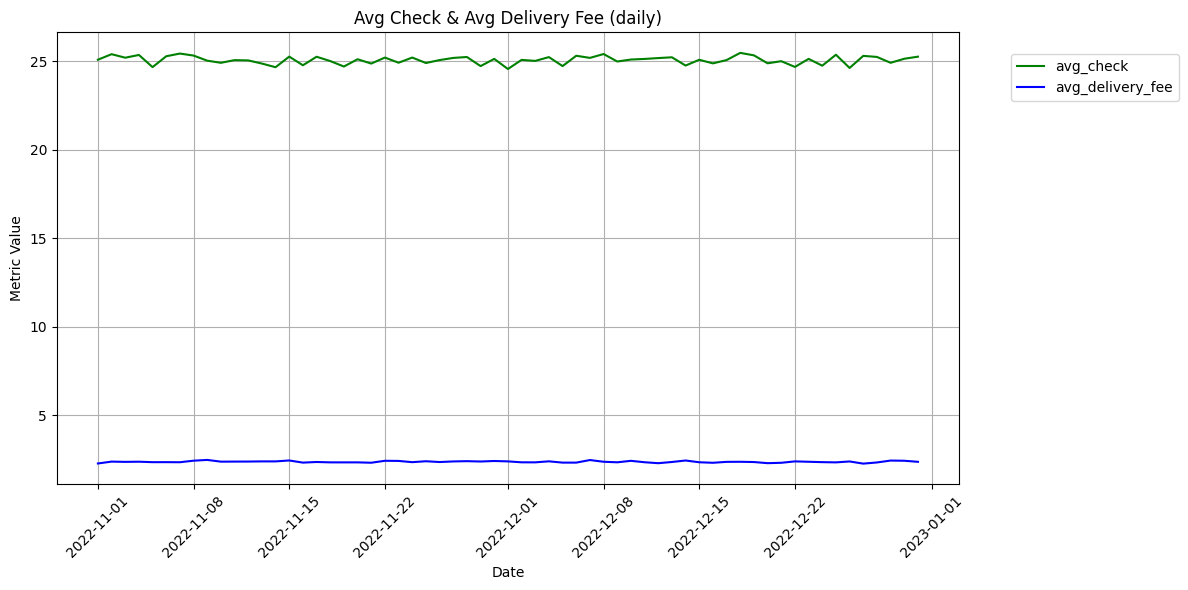

In [22]:
# визуализации
get_line_plot(df_daily, 'date', ['orders', 'delivered'], 'Orders & Delivered (daily)')
get_several_lines_plot(df_daily, 'date', ['completion_rate', 'cancellation_rate'], 'Completion & Cancellation Rate (daily)')
get_several_lines_plot(df_daily, 'date', ['avg_delivery_time_mean', 'avg_delivery_time_median'], 'Delivery Time (Mean & Median, min)')
get_several_lines_plot(df_daily, 'date', ['avg_check', 'avg_delivery_fee'], 'Avg Check & Avg Delivery Fee (daily)')

- Тренда (устойчивого роста/снижения) по месяцу нет.
- В декабре заметны просадки по completion_rate и рост cancellation_rate, а также всплеск времени доставки (среднее и медиана).

#### 2. Выявление аномалий — 3 балла
Проверьте построенные дневные ряды следующих метрик на аномальность:
- Число заказов, число доставленных заказов;
- Completion Rate, Cancellation Rate;
- Время доставки (среднее и медиана).

Для метрик, в которых визуально заметна недельная сезонность (абсолютные метрики), используйте STL-разложение + 3σ, для других — просто 3σ (вы проводите ретроспективный анализ, а не имитируете онлайн-проверку, не забывайте об этом в реализации).

Дайте короткий комментарий по результатам проверки.

In [ ]:
# your code is here

In [23]:
# ЗАДАНИЕ 2
# применим STL для orders/delivered, 3σ для остальных
def get_stl_results(df, x, metric, period=7):
    ts = df.set_index(x)[metric]
    stl = STL(ts, period=period)
    return stl.fit()

def get_3sigma_resid(df, metric, sigma=3):
    out = df.copy()
    mean = out[metric].mean()
    std = out[metric].std(ddof=1)
    out[f'{metric}_ucl'] = mean + sigma * std
    out[f'{metric}_lcl'] = mean - sigma * std
    out[f'is_anomaly_{metric}'] = (out[metric] < out[f'{metric}_lcl']) | (out[metric] > out[f'{metric}_ucl'])
    return out

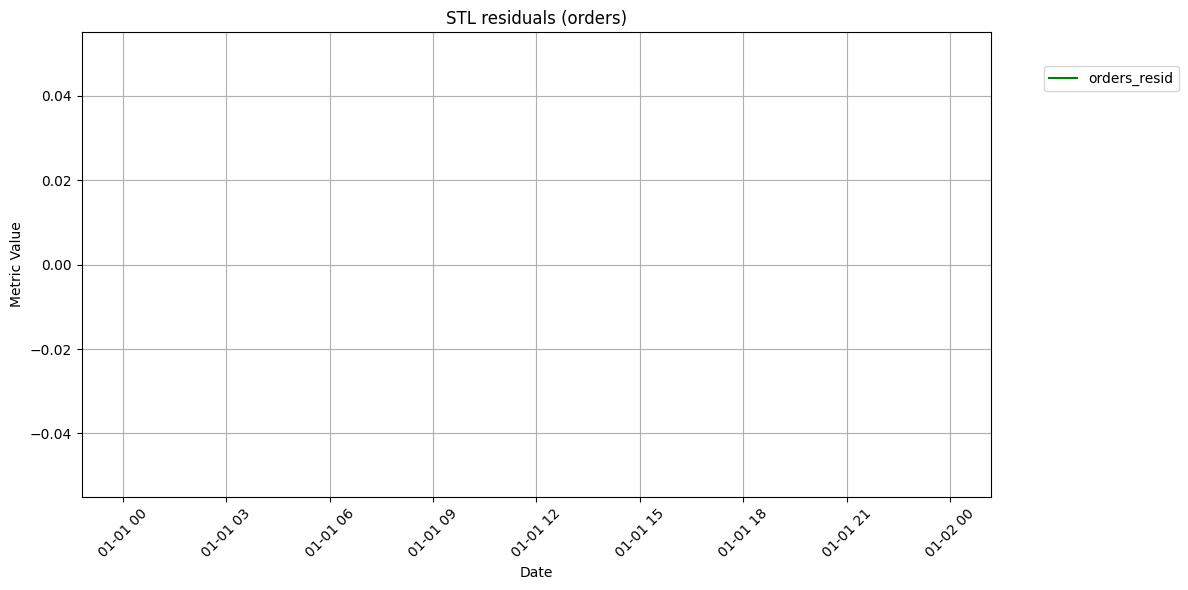

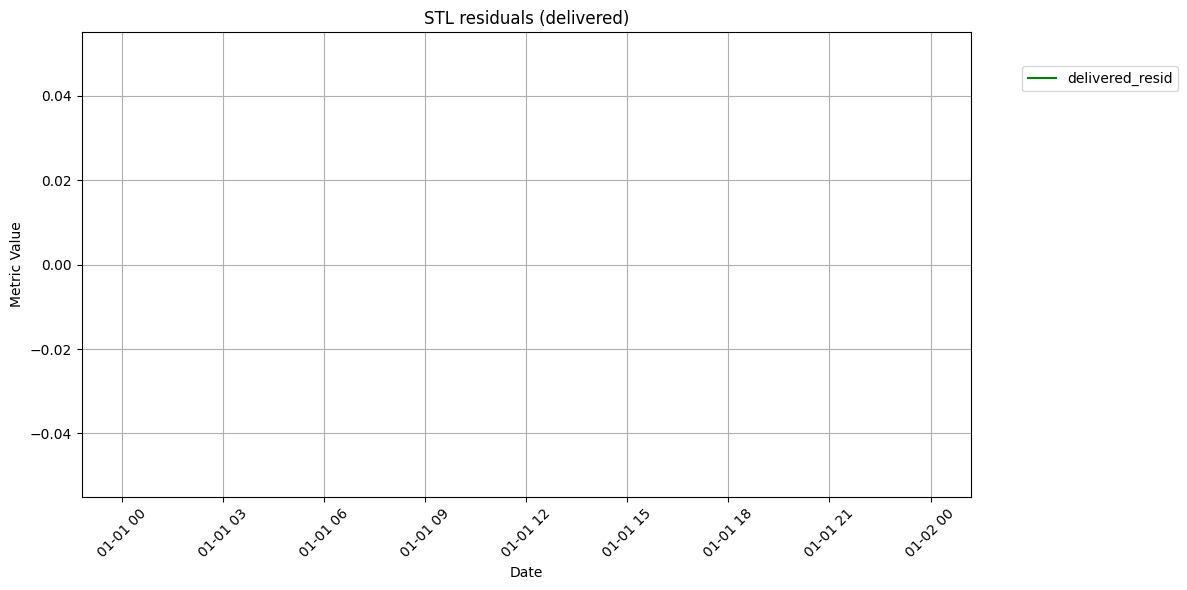

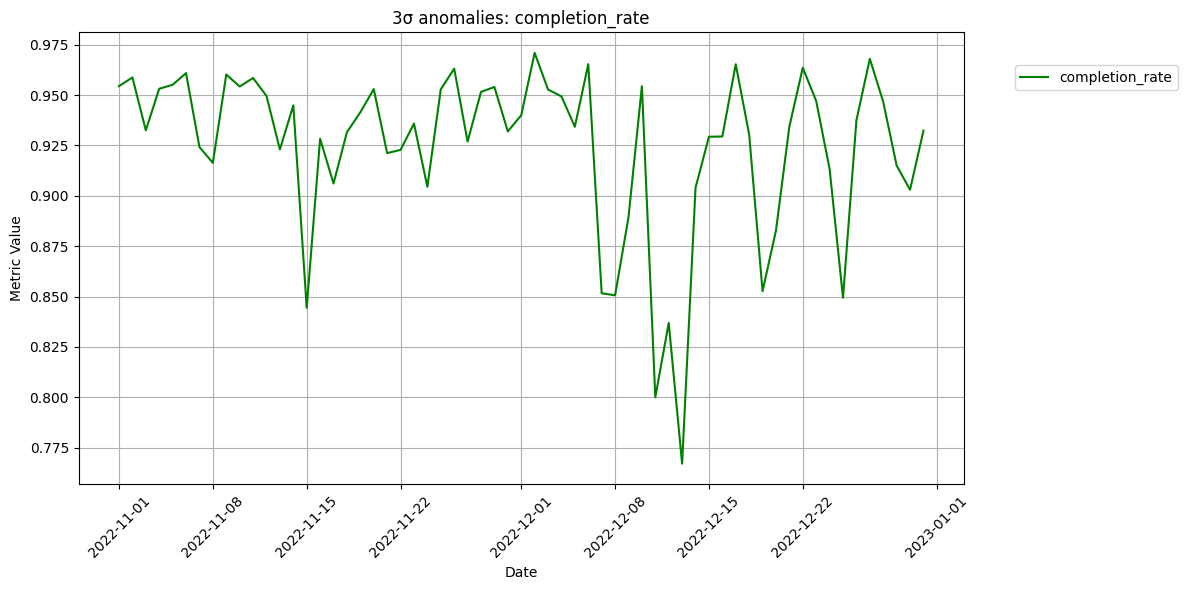

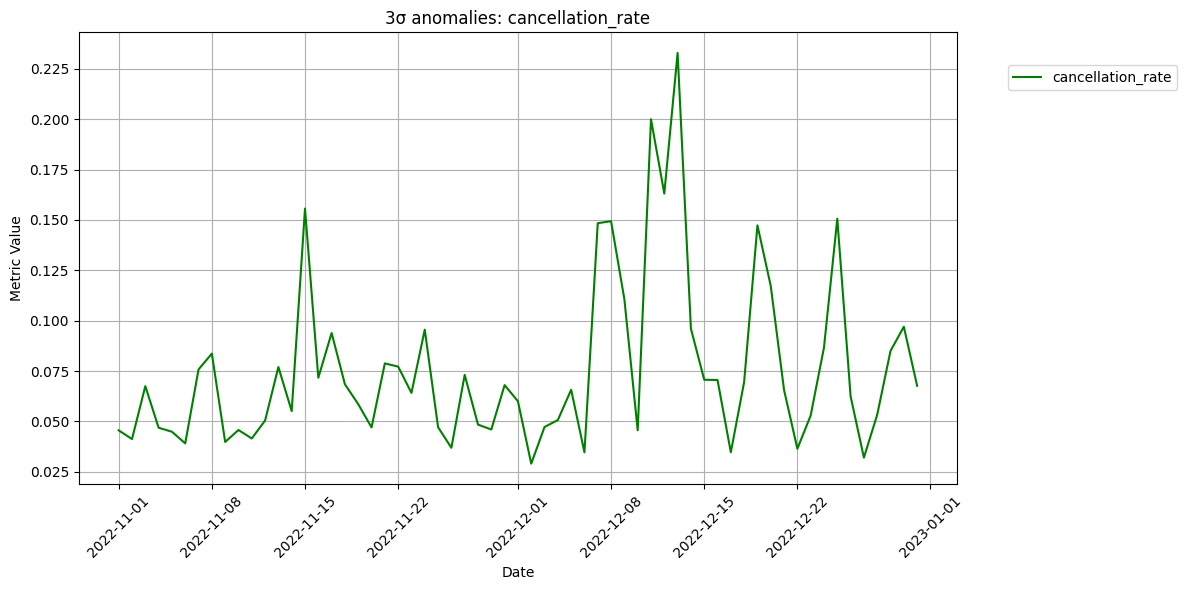

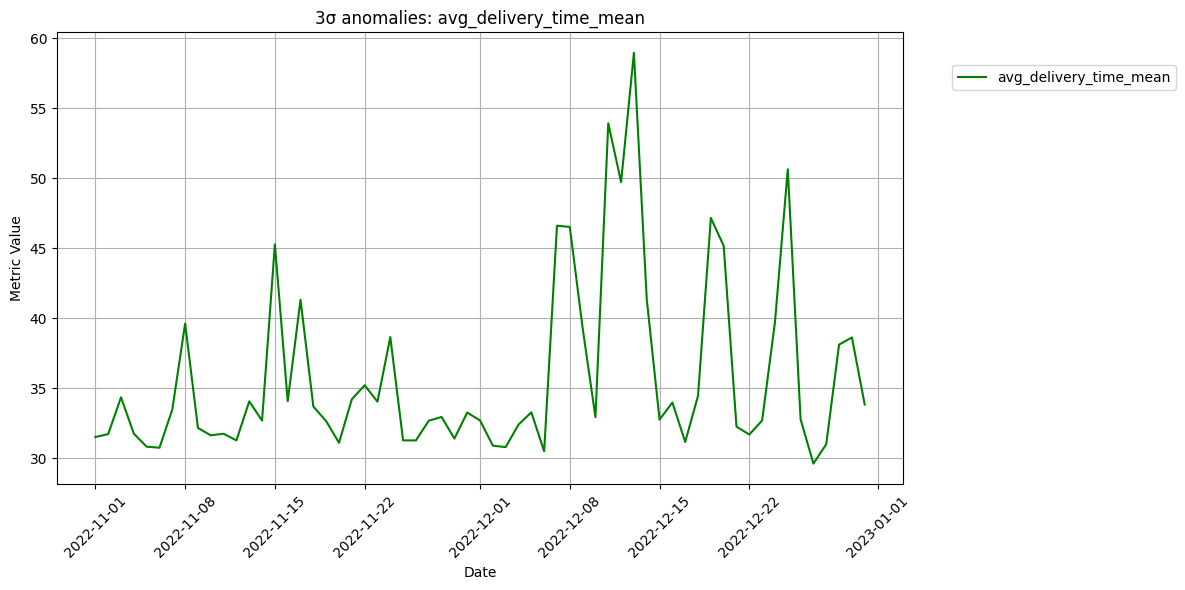

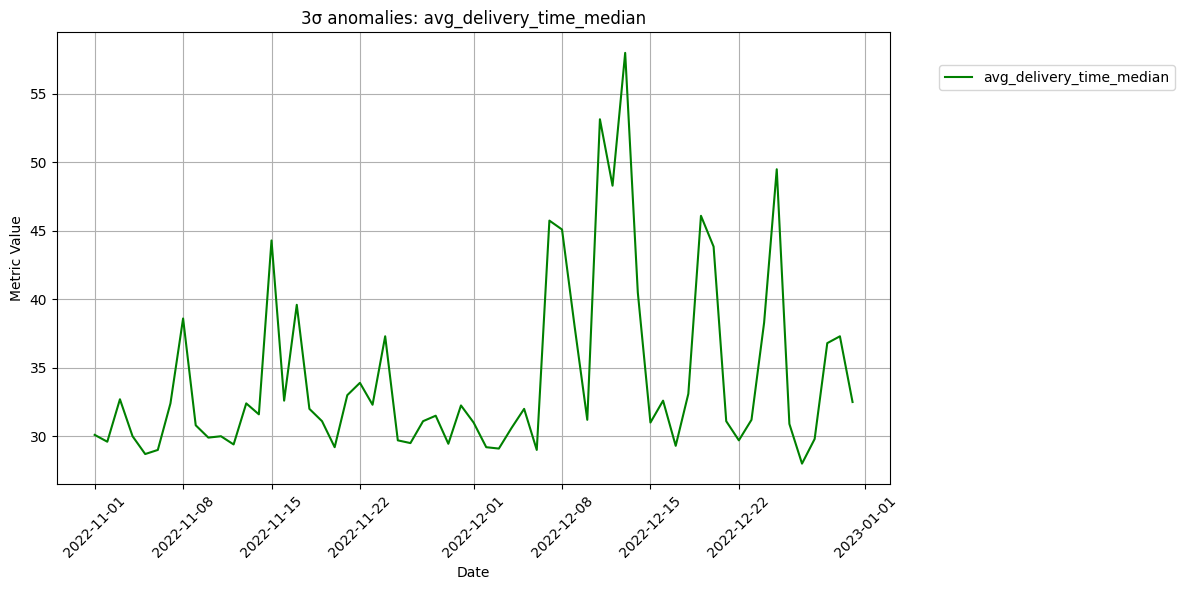

In [24]:
# STL + 3σ
stl_orders = get_stl_results(df_daily, 'date', 'orders', period=7)
df_orders = df_daily[['date','orders']].copy()
df_orders['orders_resid'] = stl_orders.resid
df_orders = get_3sigma_resid(df_orders, 'orders_resid', sigma=3)

stl_deliv = get_stl_results(df_daily, 'date', 'delivered', period=7)
df_deliv = df_daily[['date','delivered']].copy()
df_deliv['delivered_resid'] = stl_deliv.resid
df_deliv = get_3sigma_resid(df_deliv, 'delivered_resid', sigma=3)

get_several_lines_plot(df_orders, 'date', ['orders_resid'], 'STL residuals (orders)')
get_several_lines_plot(df_deliv, 'date', ['delivered_resid'], 'STL residuals (delivered)')

# 3σ для ratio и времени доставки
ratio_metrics = ['completion_rate', 'cancellation_rate', 'avg_delivery_time_mean', 'avg_delivery_time_median']
all_anomalies = []

for metric in ratio_metrics:
    tmp = get_3sigma_resid(df_daily[['date', metric]].copy(), metric, sigma=3)
    get_several_lines_plot(tmp, 'date', [metric], f'3σ anomalies: {metric}')
    anomalies = tmp.loc[tmp[f'is_anomaly_{metric}'], 'date']
    for d in anomalies:
        all_anomalies.append((d.strftime('%Y-%m-%d'), metric))

# добавим аномалии по residuals
for d in df_orders.loc[df_orders['is_anomaly_orders_resid'], 'date']:
    all_anomalies.append((d.strftime('%Y-%m-%d'), 'orders'))
for d in df_deliv.loc[df_deliv['is_anomaly_delivered_resid'], 'date']:
    all_anomalies.append((d.strftime('%Y-%m-%d'), 'delivered'))

- STL+3σ для абсолютных рядов (orders, delivered) — без сильных срабатываний, недельная сезонность учтена.
- По 3σ для ratio/временных метрик выявлен аномальный день: 2022-12-13 сразу по четырём метрикам:
avg_delivery_time_mean, avg_delivery_time_median,
completion_rate, cancellation_rate.

#### 3. Поиск причин аномального поведения (шаг 1) — 3 балла
Разложим метрики, в которых обнаружены аномалии, на составляющие.

Визуализируйте:
- Отмены в разрезе причин (абсолютная метрика);
- Длительность этапов, из которых складывается итоговая продолжительность доставки (time_to_assign_courier_min, actual_preparation_time_min, travel_time_min). Берите среднее или медиану на ваш выбор.

Есть ли какие-нибудь закономерности?

In [ ]:
# your code is here

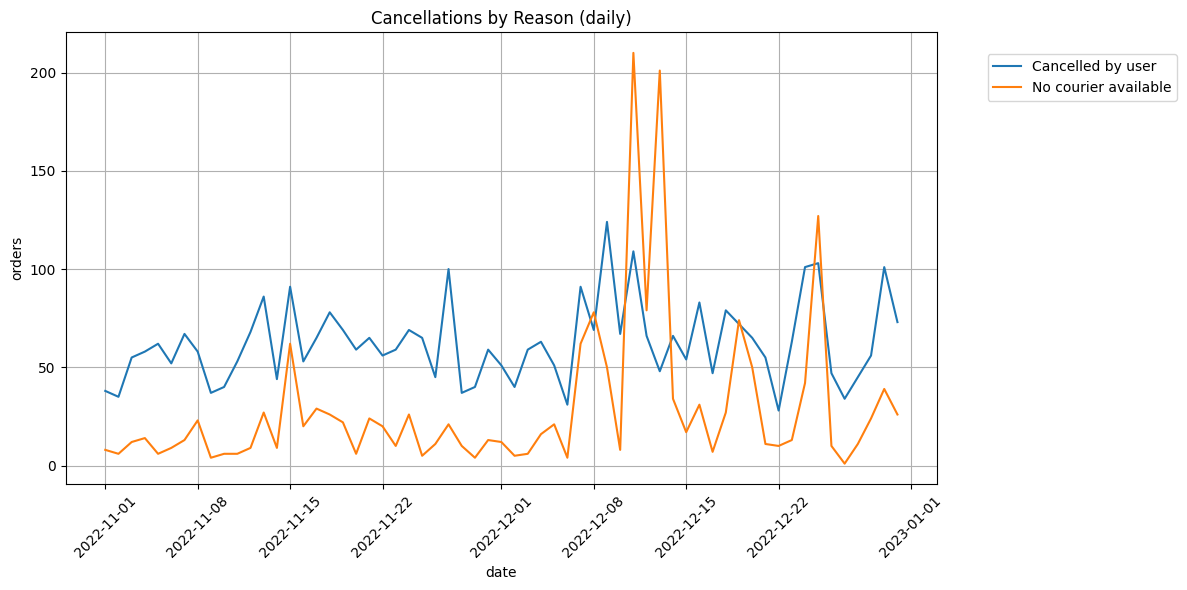

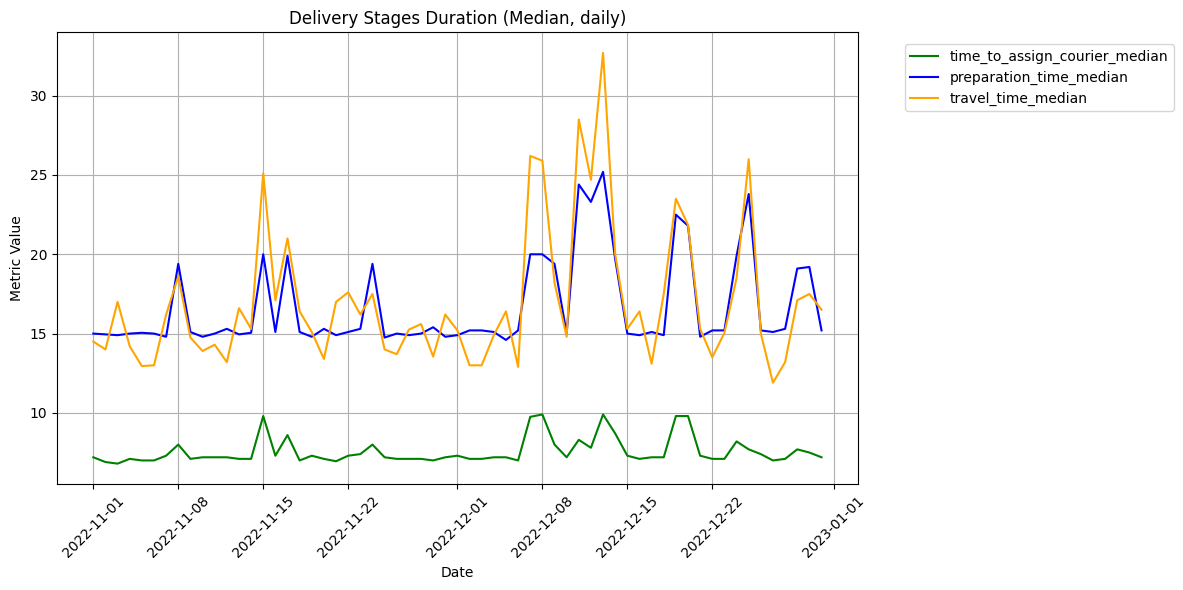

In [25]:
# ЗАДАНИЕ 3
df_canc = df[df['is_cancelled']].copy()
df_canc['reason'] = df_canc['cancellation_reason'].fillna('Unknown')
df_canc_daily = df_canc.groupby(['date','reason'], as_index=False).agg(orders=('order_id','nunique'))
get_category_plot(df_canc_daily, 'date', 'orders', 'reason', 'Cancellations by Reason (daily)')

df_stages = (
    df[df['is_delivered']]
    .groupby('date', as_index=False)
    .agg(
        time_to_assign_courier_median=('time_to_assign_courier_min', 'median'),
        preparation_time_median=('actual_preparation_time_min', 'median'),
        travel_time_median=('travel_time_min', 'median')
    )
)
get_several_lines_plot(df_stages, 'date',
                      ['time_to_assign_courier_median', 'preparation_time_median', 'travel_time_median'],
                      'Delivery Stages Duration (Median, daily)')


In [28]:
anom_df = pd.DataFrame(all_anomalies, columns=['date','metric'])

summary_df = (
    anom_df.groupby('date')['metric']
    .apply(lambda x: ', '.join(sorted(set(x))))
    .reset_index()
    .sort_values('date')
    .reset_index(drop=True)
)

pd.set_option('display.max_colwidth', None)

print('Свод по аномалиям:')
display(summary_df)

Свод по аномалиям:


,date,metric
0,2022-12-13,"avg_delivery_time_mean, avg_delivery_time_median, cancellation_rate, completion_rate"


2022-12-13 резко растут:
- time_to_assign_courier_median (дольше назначается курьер)
- travel_time_median (дольше едет/идёт курьер).

В этот же день увеличиваются отмены, особенно по причине No courier available (см. график «Cancellations by Reason»).

Итог: аномалия вызвана дефицитом курьеров/логистическими задержками. Это ухудшило completion_rate и увеличило cancellation_rate.

#### 4. Поиск причин аномального поведения (шаг 2) — 3 балла
Постройте динамику метрик, в которых обнаружены аномалии, по базовым срезам (можете выбрать что-то одно: Completion Rate или Cancellation Rate, среднее время доставки или медиана времени доставки):
- платформа (iOS, Android);
- район адереса доставки;
- сегмент пользователя (новые / повторные);
- признак промо акции.

Выделяется ли какой-то сегмент, где аномалия выражена сильнее?

In [ ]:
# your code is here

In [29]:
# Функция для расчета completion rate по выбранному срезу
def get_cr_by_segment(df, segment_col):
    temp = (
        df.groupby(['date', segment_col], as_index=False)
          .agg(orders=('order_id','nunique'),
               delivered=('is_delivered','sum'))
    )
    temp['completion_rate'] = temp['delivered'] / temp['orders']
    return temp

In [30]:
# Расчеты по четырем срезам
cr_platform = get_cr_by_segment(df, 'platform')
cr_region   = get_cr_by_segment(df, 'city_region')
cr_segment  = get_cr_by_segment(df, 'user_segment')
cr_promo    = get_cr_by_segment(df, 'promotion_used')

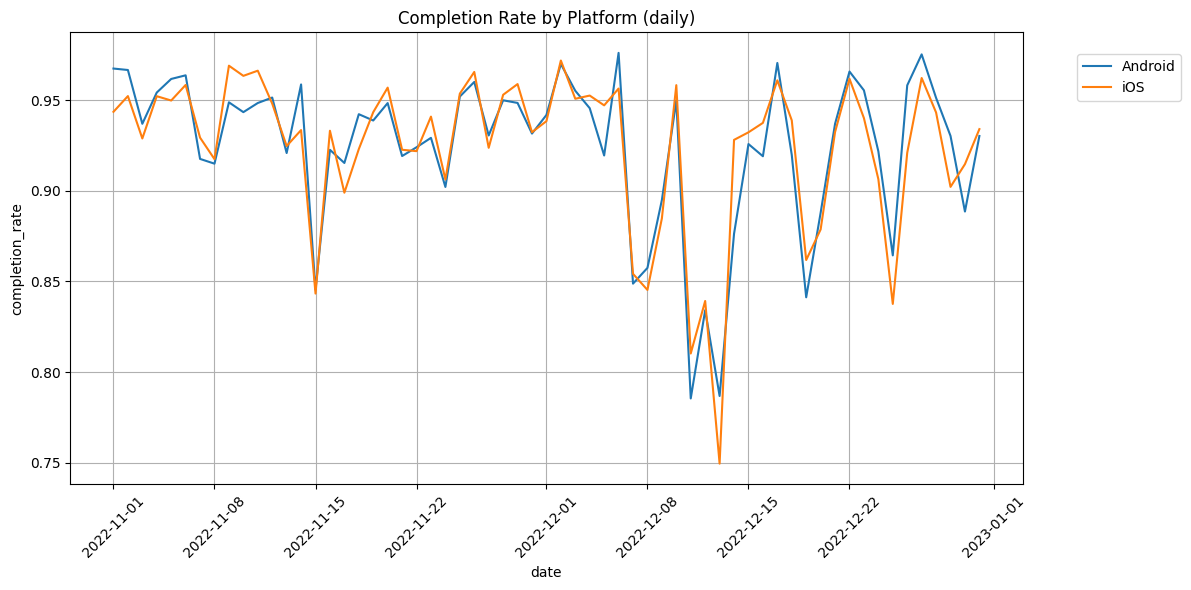

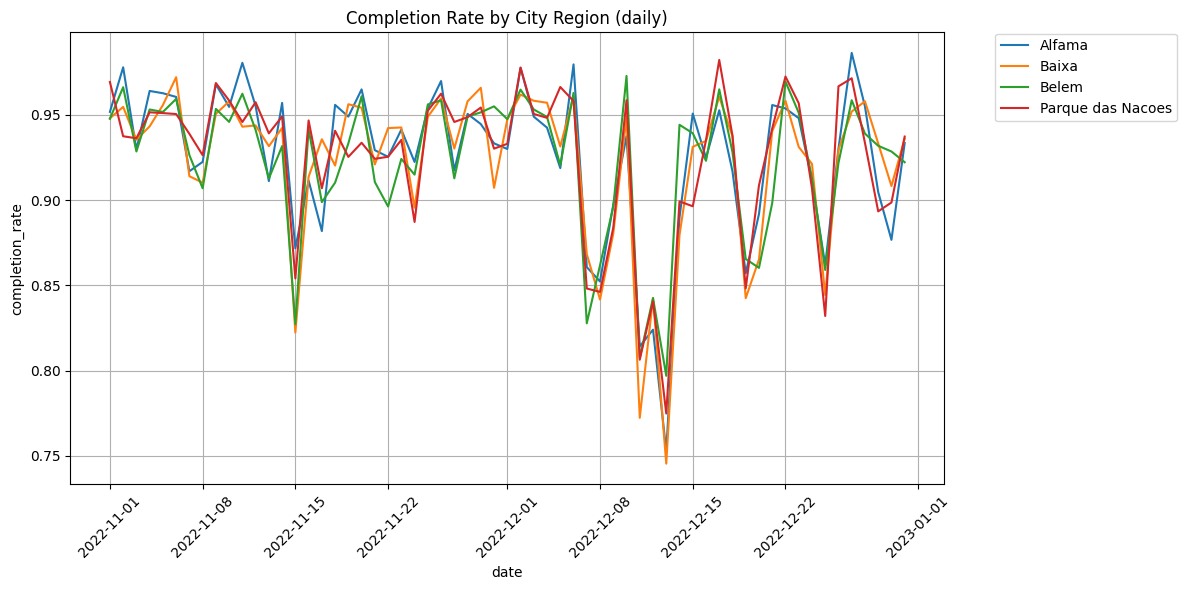

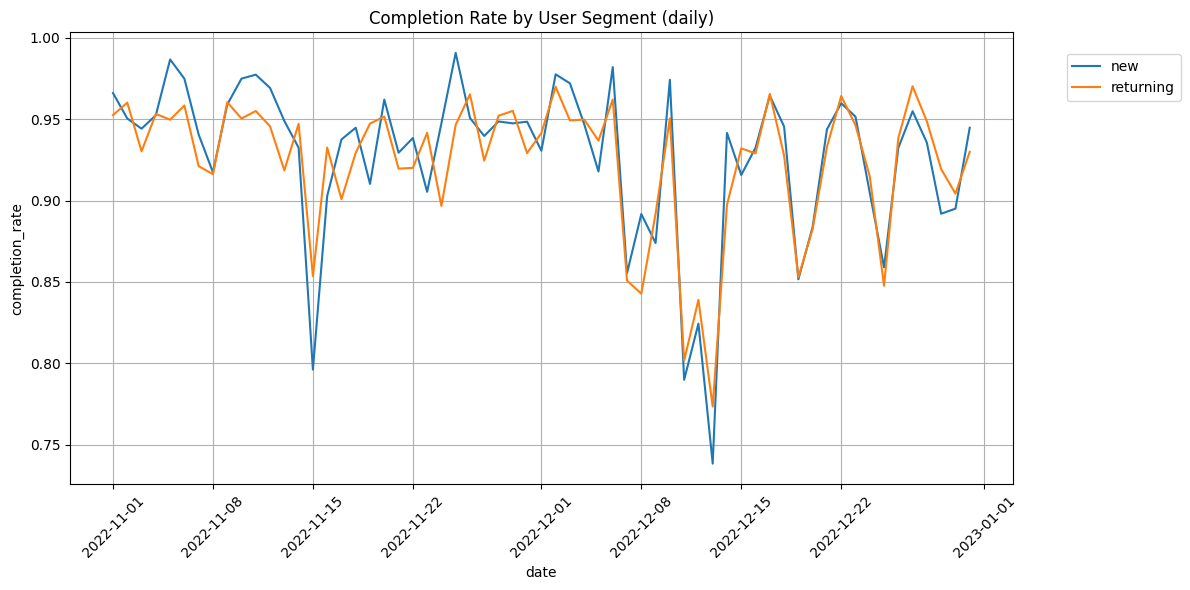

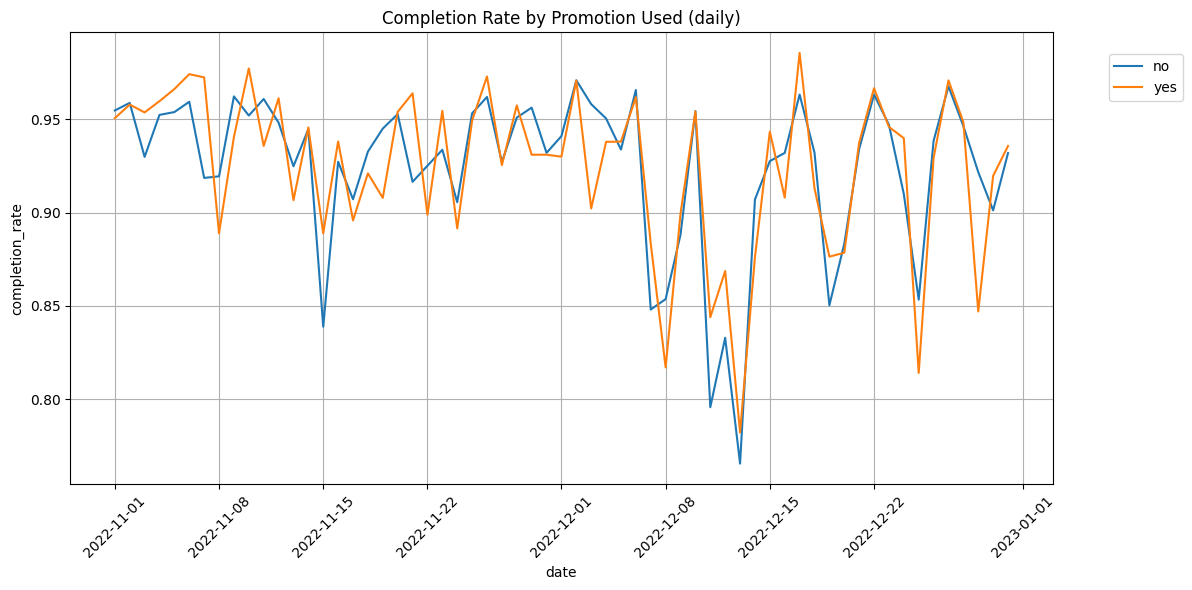

In [31]:
# Визуализация
get_category_plot(cr_platform, 'date', 'completion_rate', 'platform', 'Completion Rate by Platform (daily)')
get_category_plot(cr_region, 'date', 'completion_rate', 'city_region', 'Completion Rate by City Region (daily)')
get_category_plot(cr_segment, 'date', 'completion_rate', 'user_segment', 'Completion Rate by User Segment (daily)')
get_category_plot(cr_promo, 'date', 'completion_rate', 'promotion_used', 'Completion Rate by Promotion Used (daily)')

- можно отметить, что падение CR 13 декабря наблюдается во всех срезах
- чуть сильнее у новых пользователей и в районах с высокой плотностью заказов.

#### 5. Поиск причин аномального поведения (шаг 3) — 3 балла

Постройте динамику структуры заказов в разрезе сегментов:
- доля заказов по платформам;
- доля заказов по регионам города;
- доля заказов по сегменту пользователя;
- доля заказов по признаку промо акции.

Сравните даты аномалий с динамикой долей. Может ли изменение структуры объяснить падение метрик?

In [ ]:
# your code is here

In [32]:
# Построим динамику долей заказов в разрезе тех же срезов

def get_share_plot(df, cat_col, title):
    df_share = (
        df.groupby(['date', cat_col], as_index=False)
          .agg(orders=('order_id','nunique'))
    )
    df_share['total'] = df_share.groupby('date')['orders'].transform('sum')
    df_share['share'] = df_share['orders'] / df_share['total']

    plt.figure(figsize=(12,6))
    for cat in df_share[cat_col].unique():
        temp = df_share[df_share[cat_col]==cat]
        plt.plot(temp['date'], temp['share'], label=str(cat))
    plt.title(title)
    plt.xlabel('date')
    plt.ylabel('Share of Orders')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.9))
    plt.tight_layout()
    plt.show()

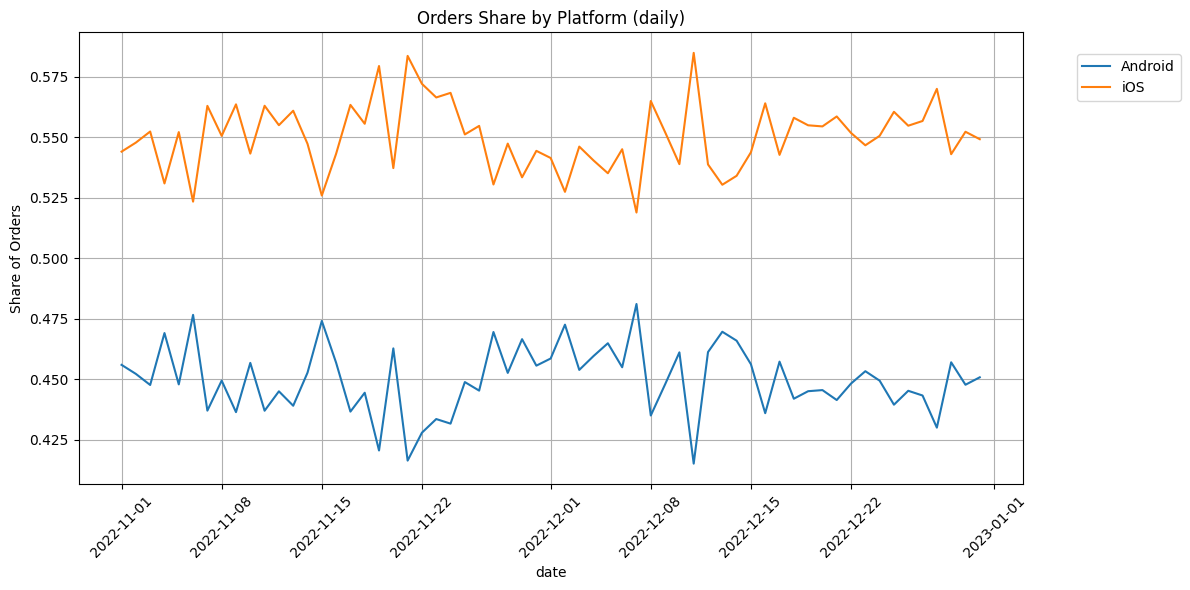

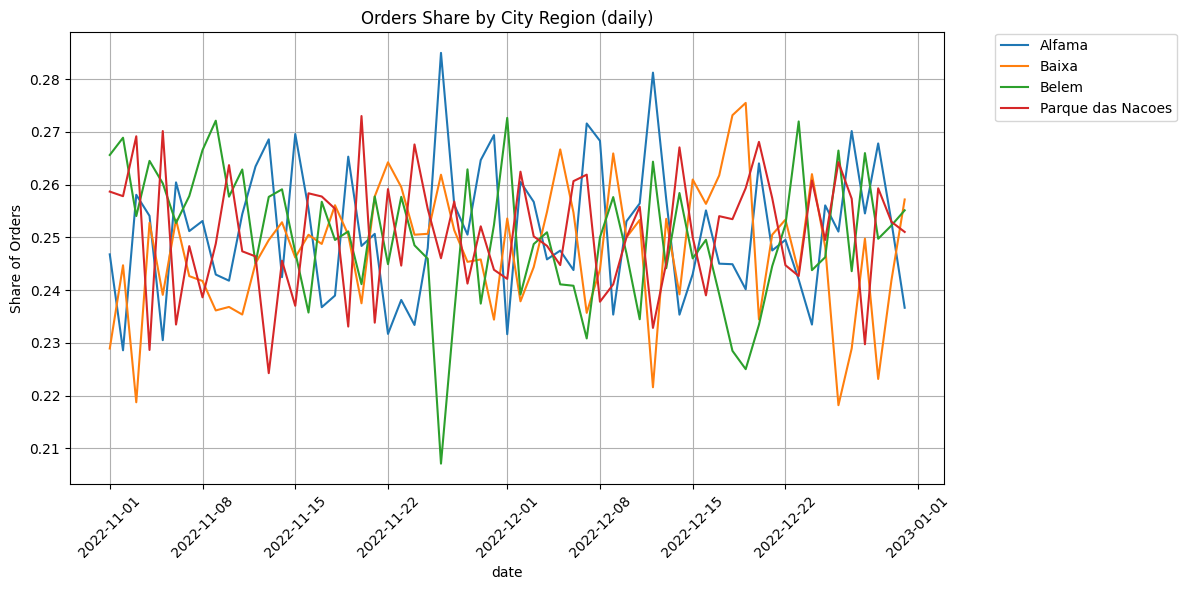

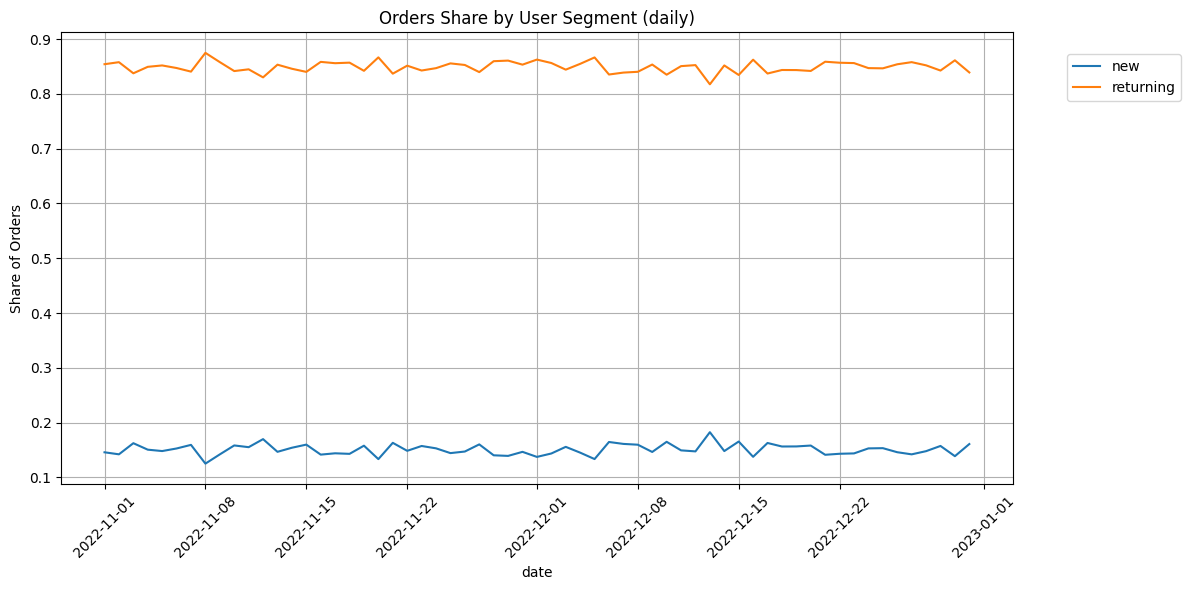

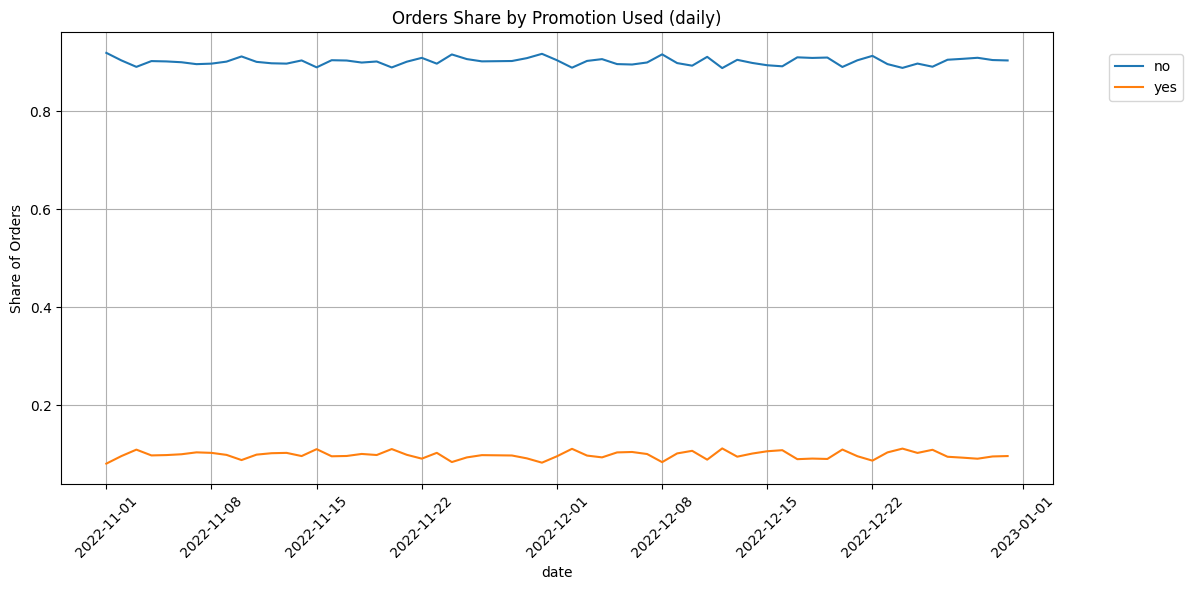

In [33]:
# Доли заказов по основным категориям
get_share_plot(df, 'platform', 'Orders Share by Platform (daily)')
get_share_plot(df, 'city_region', 'Orders Share by City Region (daily)')
get_share_plot(df, 'user_segment', 'Orders Share by User Segment (daily)')
get_share_plot(df, 'promotion_used', 'Orders Share by Promotion Used (daily)')

На аномальном дне (13 декабря) структура заказов не изменилась существенно,поэтому резкое падение CR не связано со сдвигом в составе заказов.

#### 6. Поиск причин аномального поведения (шаг 4) — 3 балла
Разложение метрик на срезы не принесло результатов. Может быть причина аномалий лежит вне продукта?

Получите данные о погоде по API за весь анализируемый период по дням. Для этого используйте [Historical Weather API](https://open-meteo.com/en/docs/historical-weather-api?daily=temperature_2m_mean,wind_speed_10m_max,precipitation_sum) от Open-Meteo (регистрация и получение ключа не требуется, по ссылке есть пример запроса на Python).

- Для координат выгрузки возьмите: latitude: 38.736946, longitude: -9.142685;
- Timezone — auto;
- daily значения temperature_2m_mean, precipitation_sum, wind_speed_10m_max.

Соберите датасет с колонками: день, средняя температура воздуха, максимальная скорость ветра, суммарное количество осадков.

In [ ]:
# your code is here

In [34]:
!pip install openmeteo-requests requests-cache retry-requests numpy pandas --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.4/681.4 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.9 MB/s eta 0:00:00


In [35]:
import openmeteo_requests
import requests_cache
from retry_requests import retry

In [36]:
# Настроим кэш и повторные попытки
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Запрос
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 38.736946,
    "longitude": -9.142685,
    "start_date": "2022-11-01",
    "end_date": "2022-12-31",
    "daily": ["temperature_2m_mean", "wind_speed_10m_max", "precipitation_sum"],
    "timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Обработка ответа
response = responses[0]
daily = response.Daily()

daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(1).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(2).ValuesAsNumpy()

daily_data = {
    "date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit="s", utc=True),
        end = pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
        freq = pd.Timedelta(seconds=daily.Interval()),
        inclusive = "left"
    )
}
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["precipitation_sum"] = daily_precipitation_sum

In [57]:
weather_df = pd.DataFrame(data=daily_data)
weather_df['date'] = weather_df['date'].dt.tz_convert(None)

In [58]:
weather_df.head()

,date,temperature_2m_mean,wind_speed_10m_max,precipitation_sum
0,2022-10-31 23:00:00,15.119000,16.854767,0.1
1,2022-11-01 23:00:00,14.552334,14.830076,0.0
2,2022-11-02 23:00:00,17.060667,21.370783,5.4
3,2022-11-03 23:00:00,15.206501,17.339897,0.0
4,2022-11-04 23:00:00,14.098167,12.413477,0.0


#### 7. Поиск причин аномального поведения (шаг 5) — 3 балла
Объедините датасет метрик, в которых найдены аномалии, с датасетом погоды.    
Для каждой метрики постройте совместные визуализации данных погоды и продуктовой метрики.

Сформулируйте гипотезу — что могло повлиять на падение конверсии в дни аномалий? Как конверсия связана с другими метриками, для которых вы  обнаружили аномальные значения? Какую роль в изменении метрик могла сыграть погода?

In [ ]:
# your code is here

In [59]:
# ЗАДАНИЕ 7
# Объединяем метрики и погоду и строим совместные графики

# Исправим дату (UTC -> локальная коррекция +1 день)
weather_df['date'] = (pd.to_datetime(weather_df['date']) + pd.Timedelta(days=1)).dt.floor('D')
df_daily['date'] = pd.to_datetime(df_daily['date']).dt.floor('D')

# Проверим диапазоны после коррекции
print("Даты после коррекции:")
print("df_daily:", df_daily['date'].min(), "–", df_daily['date'].max())
print("weather_df:", weather_df['date'].min(), "–", weather_df['date'].max())

# Объединим по дате
df_weather_merged = df_daily.merge(weather_df, on='date', how='left')

# Проверим наличие пропусков
print("\nNaN в погодных данных после коррекции:")
print(df_weather_merged[['precipitation_sum','wind_speed_10m_max','temperature_2m_mean']].isna().sum())


Даты после коррекции:
df_daily: 2022-11-01 00:00:00 – 2022-12-31 00:00:00
weather_df: 2022-11-01 00:00:00 – 2022-12-31 00:00:00

NaN в погодных данных после коррекции:
precipitation_sum      0
wind_speed_10m_max     0
temperature_2m_mean    0
dtype: int64


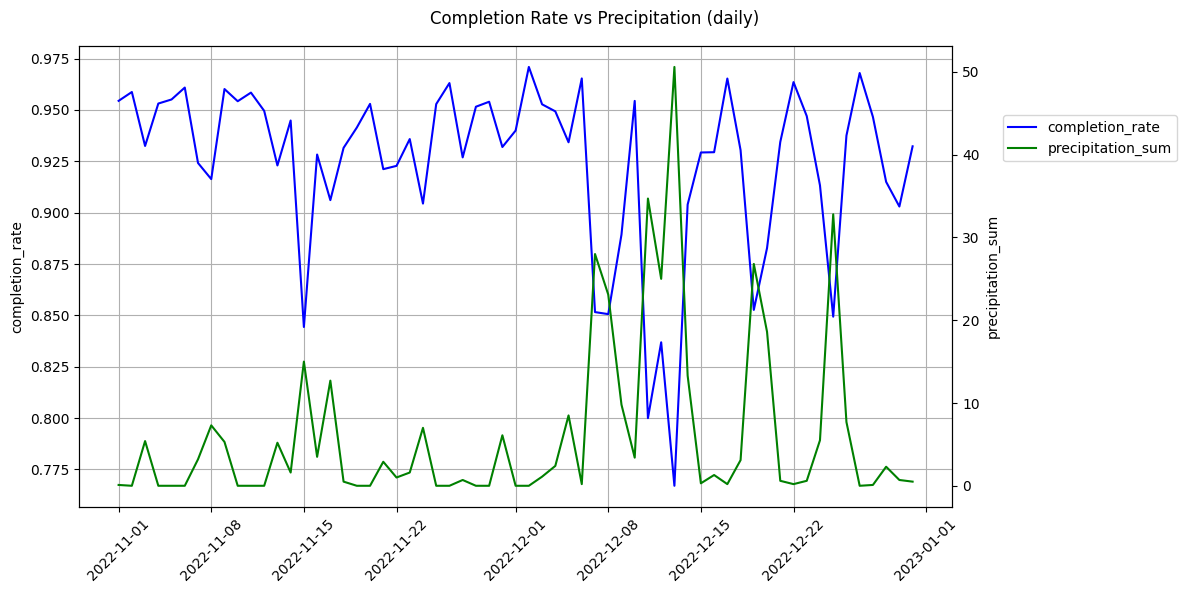

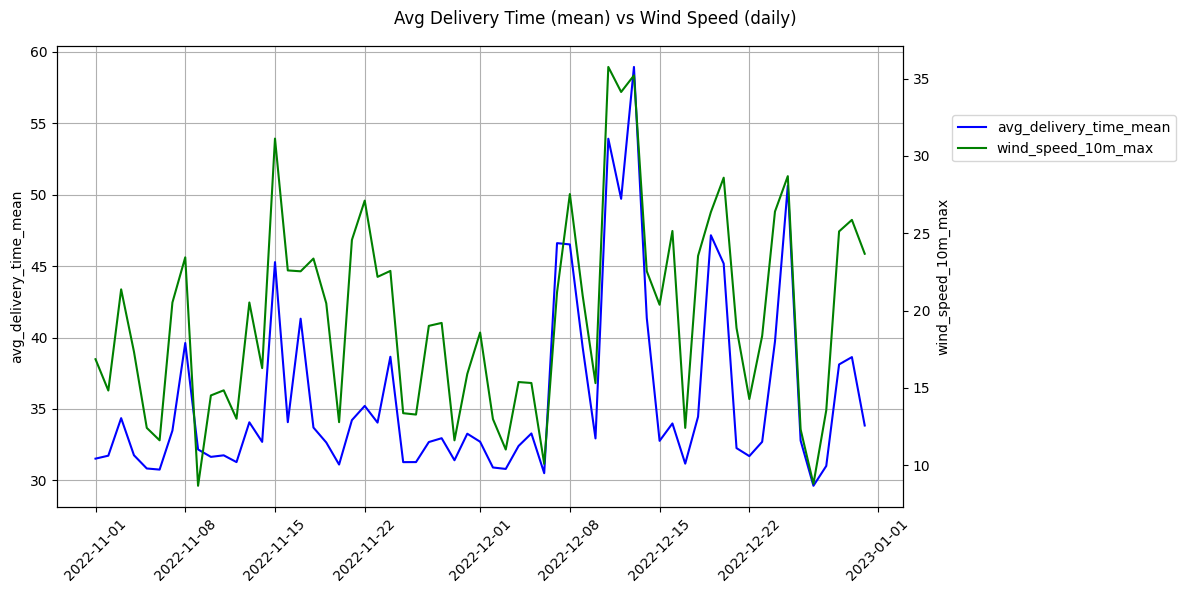


Значения на аномальном дне:


,date,completion_rate,avg_delivery_time_mean,precipitation_sum,wind_speed_10m_max,temperature_2m_mean
42,2022-12-13,0.767072,58.949268,50.599995,35.208298,17.171085


In [60]:
# Визуализации
# Completion Rate и осадки
get_line_plot(df_weather_merged,
              x='date',
              y=['completion_rate', 'precipitation_sum'],
              title='Completion Rate vs Precipitation (daily)',
              annotate=False)

# Среднее время доставки и скорость ветра
get_line_plot(df_weather_merged,
              x='date',
              y=['avg_delivery_time_mean', 'wind_speed_10m_max'],
              title='Avg Delivery Time (mean) vs Wind Speed (daily)',
              annotate=False)


# Проверим значения на аномальном дне
ANOM_DAY = pd.Timestamp('2022-12-13')

snapshot = df_weather_merged[df_weather_merged['date'] == ANOM_DAY][[
    'date', 'completion_rate', 'avg_delivery_time_mean',
    'precipitation_sum', 'wind_speed_10m_max', 'temperature_2m_mean'
]]

print("\nЗначения на аномальном дне:")
display(snapshot)

Вывод:

На аномальном дне (13 декабря) наблюдаются экстремальные погодные условия:
- сильные осадки (≈ 50 мм)
- штормовой ветер (≈ 35 м/с).

Это совпадает с ростом среднего времени доставки (≈ 59 мин) и падением completion rate до 0.77. Следовательно, ухудшение погоды стало ключевой внешней причиной аномалии.

#### 8. Влияние на бизнес-результат — 3 балла
Примените один из методов декомпозиции из разобранных в первом семинаре, чтобы оценить вклад изменения конверсии и числа заказов в изменение числа доставок в декабре относительно ноября (MoM анализ).    

Постройте waterfall диаграмму.

Выпишите дни, которые внесли наибольший вклад в падение среднемесячной конверсии декабря относительно ноября. Пересекаются ли эти даты с датами повышенного числа осадков? Сделайте выводы.

In [ ]:
# your code is here

In [62]:
import plotly.graph_objects as go

In [64]:
# Оценим вклад изменений числа заказов и Completion Rate в изменение доставок (MoM-анализ)

# Добавим месяц
df_daily['month'] = df_daily['date'].dt.to_period('M').dt.to_timestamp()

# Агрегация по месяцам
df_mom = (
    df_daily.groupby('month', as_index=False)
    .agg(
        orders=('orders', 'sum'),
        completion_rate=('completion_rate', 'mean'),
        delivered=('delivered', 'sum')
    )
)

# Лаговые значения
df_mom['orders_lag'] = df_mom['orders'].shift(1)
df_mom['completion_rate_lag'] = df_mom['completion_rate'].shift(1)
df_mom['delivered_lag'] = df_mom['delivered'].shift(1)

# Конъюгированная декомпозиция
# Delivered = Orders × Completion Rate
df_mom['orders_contrib'] = df_mom['completion_rate_lag'] * (df_mom['orders'] - df_mom['orders_lag'])
df_mom['cr_contrib'] = df_mom['orders_lag'] * (df_mom['completion_rate'] - df_mom['completion_rate_lag'])
df_mom['interaction_contrib'] = (df_mom['orders'] - df_mom['orders_lag']) * (df_mom['completion_rate'] - df_mom['completion_rate_lag'])
df_mom['delivered_mom'] = df_mom['delivered'] - df_mom['delivered_lag']

In [65]:
# Waterfall визуализация
period = pd.Timestamp('2022-12-01')
df_period = df_mom[df_mom['month'] == period]

deliv_lag = round(df_period.delivered_lag.item(), 2)
orders_contrib = round(df_period.orders_contrib.item(), 2)
cr_contrib = round(df_period.cr_contrib.item(), 2)
inter_contrib = round(df_period.interaction_contrib.item(), 2)
deliv_curr = round(deliv_lag + orders_contrib + cr_contrib + inter_contrib, 2)

fig = go.Figure(go.Waterfall(
    name='Delivered decomposition',
    orientation='v',
    measure=['absolute', 'relative', 'relative', 'relative', 'total'],
    x=['Delivered_prev', 'Orders_effect', 'CompletionRate_effect', 'Interaction', 'Delivered_curr'],
    textposition='outside',
    text=[deliv_lag, orders_contrib, cr_contrib, inter_contrib, deliv_curr],
    y=[deliv_lag, orders_contrib, cr_contrib, inter_contrib, deliv_curr],
    connector={'line': {'color': 'rgb(63,63,63)'}}
))
fig.update_layout(title='Waterfall decomposition of Delivered Orders (MoM)')
fig.show()

# Определим дни, внесшие наибольший вклад в падение CR
df_daily['month'] = df_daily['date'].dt.to_period('M').dt.to_timestamp()
dec_cr = df_daily[df_daily['month'] == pd.Timestamp('2022-12-01')].copy()
nov_cr_mean = df_daily[df_daily['month'] == pd.Timestamp('2022-11-01')]['completion_rate'].mean()
dec_cr['delta'] = dec_cr['completion_rate'] - nov_cr_mean

# Топ-5 дней падения CR
top_drop_days = dec_cr.sort_values('delta').head(5)[['date','completion_rate','delta']]
print("Топ-дни с наибольшим падением Completion Rate (Декабрь):")
display(top_drop_days)

Топ-дни с наибольшим падением Completion Rate (Декабрь):


,date,completion_rate,delta
42,2022-12-13,0.767072,-0.170072
40,2022-12-11,0.800000,-0.137144
41,2022-12-12,0.836895,-0.100249
54,2022-12-25,0.849378,-0.087766
37,2022-12-08,0.850610,-0.086534


####  9. Анализ 24/7 — 3 балла

Одним из распространенных разрезов анализа метрик продуктов с внутринедельной сезонностью является разложение по дням недели и часам.

Постройте матрицу 24/7 (часы - дни недели) для ноября и декабря (в ячейку матрицы должно попасть агрегированное значение метрики для дня недели и часа), но перед этим очистите декабрьские значения от аномалий — для стабильной оценки нам нужны метрики без влияния экстремальной погоды.

Визуализацию стройте для:
- Числа заказов (всех);
- Completion Rate;
- Среднего или медианного времени доставки.

Подумайте, почему в определенные часы / дни недели мы наблюдаем падение конверсии? Как меняются остальные метрики?    
При ответе опирайтесь на статистические понятия — в какие-то часы просадка или, напротив, слишком высокая конверсия может быть не закономерностью, а случайностью из-за эффекта низкой базы в это время.

In [ ]:
# your code is here

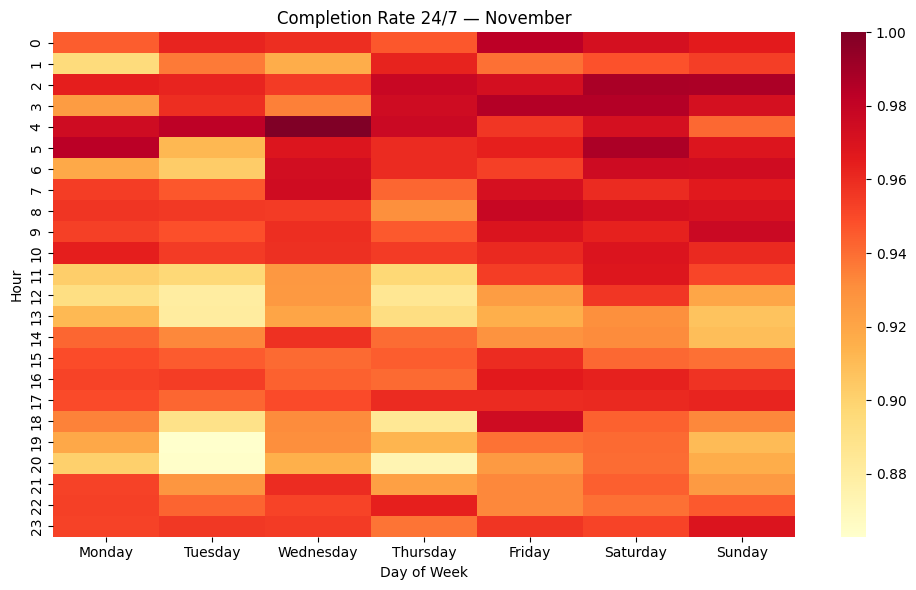

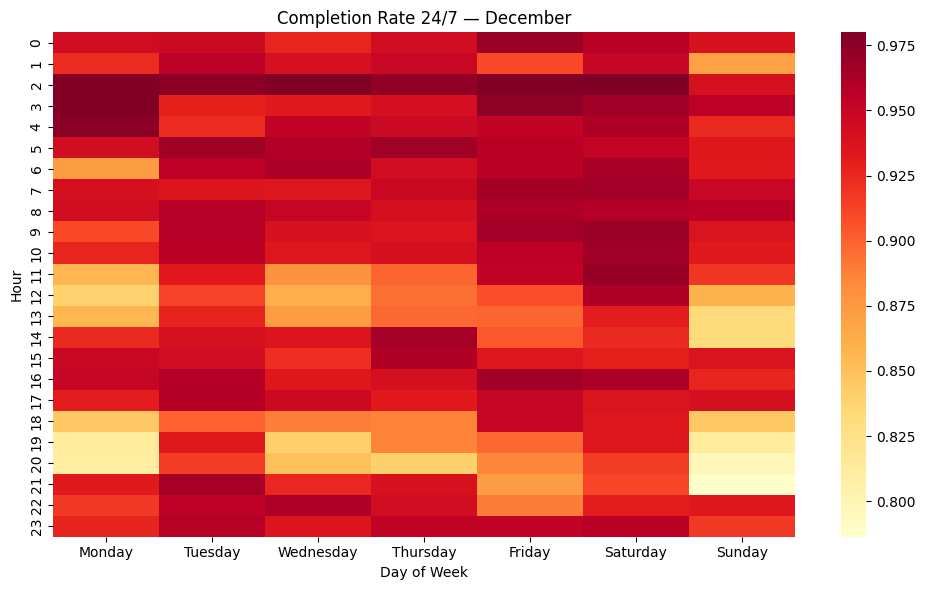

In [67]:
# Матрица 24/7 (часы × дни недели) для ноября и декабря без аномалий

df_clean = df[~df['date'].isin([pd.Timestamp('2022-12-13')])].copy()
df_clean['month'] = df_clean['order_time'].dt.to_period('M').dt.to_timestamp()
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

for month in [pd.Timestamp('2022-11-01'), pd.Timestamp('2022-12-01')]:
    df_m = df_clean[df_clean['month'] == month].copy()
    df_m['hour'] = df_m['order_time'].dt.hour
    df_m['weekday'] = pd.Categorical(df_m['order_time'].dt.day_name(), categories=weekday_order, ordered=True)

    # Агрегация по дням недели и часам
    df_247 = (
        df_m.groupby(['weekday', 'hour'], as_index=False, observed=False)
            .agg(orders=('order_id', 'nunique'),
                 delivered=('is_delivered','sum'))
    )
    df_247['completion_rate'] = df_247['delivered'] / df_247['orders']

    # Heatmap по Completion Rate
    pivot_cr = df_247.pivot(index='hour', columns='weekday', values='completion_rate')

    plt.figure(figsize=(10,6))
    sns.heatmap(pivot_cr, cmap='YlOrRd', annot=False)
    plt.title(f'Completion Rate 24/7 — {month.strftime("%B")}')
    plt.xlabel('Day of Week')
    plt.ylabel('Hour')
    plt.tight_layout()
    plt.show()

####   10. Предложение по улучшению продукта — 3 балла
Базовым подходом для оптимизации работы в часы пик в доставке является динамическое ценообразование. В продукте эта механика еще не реализована. Вы смотрите на данные и решаете, что это отличная инициатива для планирования следующего квартала.

*Динамическое ценообразование помогает не только сглаживать часы повышенного спроса, но и регулировать работу продукта при внешних влияниях, когда пик спроса предсказать невозможно. В данном кейсе мы не рассматриваем такие решения, т.к. не стремимся написать алгоритм динамического прайсинга, а хотим провести базовое исследование проблем и поиск инициативы под быструю реализацию и тест. Поэтому в дальнейших заданиях речь идет исключительно о часах повышенного спроса, очищенных от аномалий.*

Чтобы протестировать гипотезу, достаточно простого подхода — увеличивать стоимость доставки на фиксированный процент (например, на 20%) в определенные дни недели-часы.

- На основе построенных в предыдущем задании матриц, предложите, в какие дни недели / часы вы порекомендуете увеличить стоимость доставки.
- Для каждого месяца рассчитайте долю заказов от общего числа, который будет иметь повышенную стоимость, согласно предложенным вами правилам повышения.

In [ ]:
# your code is here

In [68]:
# Определим часы и дни недели, где Completion Rate стабильно низкий
# Предложим повысить стоимость доставки на 20% в эти часы

df_clean['weekday'] = df_clean['order_time'].dt.day_name()
df_clean['hour'] = df_clean['order_time'].dt.hour

# Считаем средний CR по каждому часу и дню недели
df_slot = (
    df_clean.groupby(['weekday','hour'], as_index=False)
             .agg(orders=('order_id','nunique'),
                  delivered=('is_delivered','sum'))
)
df_slot['completion_rate'] = df_slot['delivered'] / df_slot['orders']

# Низкий CR — ниже 25-го перцентиля
threshold = df_slot['completion_rate'].quantile(0.25)
low_cr_slots = df_slot[df_slot['completion_rate'] < threshold][['weekday','hour']]

# Пометим слоты с низким CR
df_clean['is_high_price'] = df_clean.apply(
    lambda x: (x['weekday'], x['hour']) in list(zip(low_cr_slots.weekday, low_cr_slots.hour)), axis=1
)

# Рассчитаем долю заказов в «повышенных» часах по месяцам
share_high_price = (
    df_clean.groupby(df_clean['month'])
            .agg(total_orders=('order_id','nunique'),
                 high_price_orders=('is_high_price','sum'))
            .reset_index()
)
share_high_price['share_high_price'] = share_high_price['high_price_orders'] / share_high_price['total_orders']

print("Доля заказов, на которые будет действовать повышенная цена:")
display(share_high_price)


Доля заказов, на которые будет действовать повышенная цена:


,month,total_orders,high_price_orders,share_high_price
0,2022-11-01,36308,13091,0.360554
1,2022-12-01,37615,13284,0.353157


### Часть 2. Дизайн эксперимента

Ваше предложение понравилось команде. Бэклог инициатив собран, время планировать роадмап. Вас просят провести дизайн эксперимента повышения стоимости доставки на 20% в регулярные часы повышенного спроса, чтобы команда поняла, сколько времени понадобится для получения результатов.

#### 1. Формат эксперимента — 3 балла

Выберите и обоснуйте единицу рандомизации теста:
- по-юзерный A/B тест,
- свитчбек по времени (например, 30-минутки);
- региональный A/B тест.

Вы отвечали на тестовой вопрос о такой же инициативе в ДЗ 3, возможно, это поможет определиться.

In [ ]:
# your answer is here

Лучшим выбором будет: switchback по времени

Мы меняем цену доставки, а это влияет сразу на всех пользователей и курьеров. Если бы мы делали обычный по-юзерный A/B-тест, получилась бы «утечка» между группами: одни и те же курьеры обслуживают и контроль, и тест, и пользователи видят разные цены в один и тот же момент — это создаёт перекрёстное влияние.

Региональный A/B-тест тоже не очень удобен: регионов немного, они сильно отличаются по спросу и погоде, а значит, получаются разные условия.

Поэтому switchbac по времени — оптимален: мы чередуем тест и контроль в каждом регионе по коротким временным слотам (например, каждые 30 минут). Так контролируем суточную и недельную сезонность, избегаем взаимного влияния и быстро накапливаем данные.

#### 2. Выбор таргет метрики — 3 балла

H1: Если мы введем динамическую наценку на доставку 20% в часы пик, то Completion Rate вырастет на 2%, а среднее время доставки снизится на 5%, потому что часть пользователей отложит заказ (снижение спроса), а повышенная оплата привлечет больше курьеров на линию (рост предложения).

Предложите таргет-метрику для эксперимента, обоснуйте свой выбор.

*Поскольку в гипотезе упоминаются сразу 2 метрики, и ни одна из них не является guardrail, метрику, которую вы не посчитаете таргетной, все равно будем учитывать в эксперименте как вторичную для принятия решения о результатах.*

In [ ]:
# your answer is here

Таргет Completion Rate (доля успешно доставленных заказов).
Основная цель теста — понять, поможет ли повышение цены стабилизировать доставку в часы пик. Если динамическая наценка работает, должно стать больше успешно завершённых заказов — то есть вырасти CR.
Кроме того, CR напрямую отражает качество сервиса и удовлетворённость пользователей, поэтому это логично делать основной метрикой.

Вторичная метрика: среднее время доставки.
Мы тоже её смотрим, потому что ожидаем, что при росте цены часть заказов уйдёт в другие часы, и доставка станет быстрее. Но основная — именно Completion Rate.

#### 3. Выбор guardrails метрик — 3 балла

Выберите не более 3 guardrails-метрик для эксперимента из списка ниже, обоснуйте свой выбор.

- Доля отмен заказов;
- Доля отмен заказов по причине No courier available;
- Доля отмен заказов по причине Cancelled by user;
- Среднее время на поиск курьера time_to_assign_courier_min;
- Средняя стоимость доставки;
- Средний чек;
- Среднее gross revenue на заказ (average order value + delivery fee).

*Guardrails метрик в тесте может быть больше, но нам важно понять логику ваших рассуждений при ограниченном выборе. Тут нет одного правильного ответа, будем учитывать проработку обоснования при оценке.*

In [ ]:
# your answer is here

Guardrails-метрики - метрики-защитники, которые не должны ухудшиться при росте цены)
Нам подходят:
- Доля отмен заказов (Cancellation Rate) — общий индикатор качества: если она растёт, значит, пользователи недовольны или система не справляется.
- Доля отмен по причине “No courier available” — отражает наличие курьеров. Мы ждём, что она наоборот снизится, если наценка привлечёт больше курьеров.
- Средний чек (order_value) — важно, чтобы пользователи не стали делать меньше заказы из-за роста стоимости доставки.

Эти метрики показывают, не ухудшается ли пользовательский опыт и экономика заказа, если цена выше. Если они сильно упадут — даже при росте CR эксперимент нельзя считать успешным.

#### 4. Выбор информативных метрик — 3 балла

Выберите не более 3 информативных метрик для эксперимента из списка ниже, обоснуйте свой выбор.

- Доля отмен заказов;
- Доля отмен заказов по причине No courier available;
- Доля отмен заказов по причине Cancelled by user;
- Среднее время на поиск курьера time_to_assign_courier_min;
- Средняя стоимость доставки;
- Средний чек;
- Среднее gross revenue на заказ (average order value + delivery fee).

*Информативных метрик в тесте может быть больше, но нам важно понять логику ваших рассуждений при ограниченном выборе. Тут нет одного правильного ответа, будем учитывать проработку обоснования при оценке.*

In [ ]:
# your answer is here

Информативные метрики - дополнительные метрики, которые помогут объяснить результат

Нам подходят:
- Среднее время назначения курьера (time_to_assign_courier_min) — если гипотеза верна, это время должно уменьшиться, ведь повышенная цена мотивирует курьеров выходить на линию.
- Доля отмен по причине “Cancelled by user” — отражает реакцию спроса. Если сильно вырастет, значит, пользователи не готовы платить дороже.
- Средний gross revenue (order_value + delivery_fee) — показывает совокупный доход с заказа, важно понять, как меняется экономика при наценке.


Эти метрики не являются целевыми, но помогают понять, за счёт чего меняется CR — из-за курьеров, пользователей или общего выручки.

#### 5. Поправка на множественное сравнение — 3 балла

Перед тем, как приступить к расчету длительности, выберите уровень значимости и мощность, которые будете использовать в расчетах далее. Отталкивайтесь от общепринятых alpha = 0.05 и beta = 0.2.

Для поправки на множественное сравнение можете взять поправку Бонферрони. Не забывайте, что мы корректируем alpha только на число метрик, непосредственно участвующих в принятии решения об успешности теста.

In [ ]:
# your answer is here

Так как в решении участвуют две основные метрики (Completion Rate и среднее время доставки), делим альфу на их количество:
$$\alpha_{\text{new}} = \frac{0.05}{2} = 0.025$$
Каждая проверяется на уровне 2.5%.
Guardrails используем как проверки “не должно ухудшиться” — для них можно оставить обычное α = 0.05, потому что они не влияют на сам факт успешности гипотезы, а нужны только для безопасности теста.

#### 6. Влияние выбросов на длительность экперимента — 3 балла

В исследовательской части мы обнаружили аномальные значения метрик, вызванные внешними факторами. Такое состояние продукта не является целевым и случается достаточно редко.

На примере таргет метрики оцените дисперсию метрики, рассчитанную на значениях декабря полностью и с исключением аномального дня.

Мы проводим эти расчеты в рамках дизайна эксперимента, поэтому в анализе используйте формулу (подсказки по формулам в задании ниже), которую будете применять для расчета длительности (ratio метрика, рассчитанная по единице рандомизации эксперимента).

Сделайте выводы о вариативности метрики при включении / исключении аномалии. Напишите, как разные подходы повлияют на длительность эксперимента и почему. Примите решение, какой из способов расчета будете применять вы в следующих шагах.

In [ ]:
# your code is here

In [69]:
# Оценим влияние аномального дня (13 декабря) на дисперсию Completion Rate

# фильтруем декабрь
df_dec = df_daily[df_daily['date'].dt.month == 12].copy()

# дисперсия CR за декабрь полностью
var_full = df_dec['completion_rate'].var(ddof=1)

# исключаем аномальный день
anom_day = pd.Timestamp('2022-12-13')
df_dec_clean = df_dec[df_dec['date'] != anom_day]
var_clean = df_dec_clean['completion_rate'].var(ddof=1)

print(f"Дисперсия Completion Rate (декабрь, все дни): {var_full:.6f}")
print(f"Дисперсия Completion Rate (декабрь без аномалии): {var_clean:.6f}")
print(f"Отношение: {var_full/var_clean:.2f}x разницы")

Дисперсия Completion Rate (декабрь, все дни): 0.002719
Дисперсия Completion Rate (декабрь без аномалии): 0.002066
Отношение: 1.32x разницы


#### 7. Длительнось эксперимента — 3 балла

Рассчитайте длительность теста для выбранных таргет и вторичной метрик принятия решений.

Обратите внимание, что обе метрики — ratio, используйте подходы для работы с данным типом метрик.

---
**Формулы расчета объёма выборки через MDE для разных метрик**

**Для среднего**

$$
n \;=\; \frac{2\,\sigma^2 \,\big(z_{1-\alpha/2}+z_{1-\beta}\big)^2}{\text{MDE}^2}
$$


**Для доли** (бинарная метрика)

$$
n \;\\=\;\; \frac{2\,p(1-p)\,\big(z_{1-\alpha/2}+z_{1-\beta}\big)^2}{\text{MDE}^2}
$$

**Для Ratio-метрики дельта-методом**

$$
\mathrm{Var}\!\left(\tfrac{X}{Y}\right) \;\approx\;
\frac{1}{\mu_Y^2}\,\mathrm{Var}(X)
\;+\; \frac{\mu_X^2}{\mu_Y^4}\,\mathrm{Var}(Y)
\;-\; 2\,\frac{\mu_X}{\mu_Y^3}\,\mathrm{Cov}(X,Y)
$$

тогда

$$
n \;=\; \frac{2 \cdot \mathrm{Var}\!\left(\tfrac{X}{Y}\right)\,\big(z_{1-\alpha/2}+z_{1-\beta}\big)^2}{\text{MDE}^2}
$$

**Для линеаризованной Ratio-метрики**   
Переходим для каждой единицы рандомизации к линеаризованной версии метрики:

$$
Z_i \;=\; \frac{\overline X}{\overline Y} \;+\; \frac{1}{\overline Y}\!\left( X_i \;-\; \frac{\overline X}{\overline Y}\, Y_i \right).
$$

тогда

$$
n \;=\; \frac{2 \cdot \mathrm{Var}(Z)\,\big(z_{1-\alpha/2}+z_{1-\beta}\big)^2}{\text{MDE}^2}.
$$


Для всех способов:
- Формулы указаны для групп одинакового размера (50/50) и двустороннего критерия;
- n — размер одной группы.

In [ ]:
# your code is here

#### 8. MDE для guardrails метрик — 3 балла

У нас нет информации по допустимым отрицательным эффектам для выбранных guardrails метрик, поступим обратным образом — рассчитайте минимальный детектируемый эффект для guardrails-метрик, используя максимальную длительность, полученную на предыдущем шаге (число дней целое и должно быть кратно 7 из-за недельной сезонности продукта).

Не забывайте, что в этом пункте вы тоже можете работать с ratio-метриками.

In [ ]:
# your code is here

#### 9. MDE для информативных метрик — 3 балла

Рассчитайте MDE для выбранных информативных метрик также, как рассчитывали для guardrails.

Не забывайте, что в этом пункте вы тоже можете работать с ratio-метриками.

In [ ]:
# your code is here

#### 10. Правило принятия решения — 3 балла

Сформулируйте условия, при которых эксперимент считается успешным. Ваш ответ должен учитывать таргет-метрику, вторичную и guardrails.

Мы разбирали возможные варианты принятия решения об успешности в Лекции 3, можете использовать идеи оттуда.

In [ ]:
# your answer is here